# Adaptive PDE discretizations on Cartesian grids
## Volume : Reproducible research
## Part : Convergence rates
## Chapter : Pucci and Monge-Ampere equations

This notebook reproduces the numerical experiments presented in the proceedings paper

J. F. Bonnans, G. Bonnet, J.-M. Mirebeau, *Monotone and second order consistent discretization of the Pucci and Monge-Ampere operators*, submitted 2019

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Synthetic solutions and domain](#1.-Synthetic-solutions-and-domain)
  * [2. Problem data](#2.-Problem-data)
    * [2.1 Right hand side](#2.1-Right-hand-side)
    * [2.2 Rotation by Pi/6](#2.2-Rotation-by-Pi/6)
    * [2.3 Grid parameters](#2.3-Grid-parameters)
  * [3. Pucci equation](#3.-Pucci-equation)
    * [3.1 Smooth solutions](#3.1-Smooth-solutions)
    * [3.2 Non-smooth solutions](#3.2-Non-smooth-solutions)
  * [4. Monge-Ampere](#4.-Monge-Ampere)
    * [4.1 Smooth solutions](#4.1-Smooth-solutions)
    * [4.2 Non-smooth solutions](#4.2-Non-smooth-solutions)
    * [4.3 Piecewise linear degenerate solution](#4.3-Piecewise-linear-degenerate-solution)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('PucciMongeAmpere','Repro'))

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import norm
import functools
import itertools

In [3]:
from agd import Selling
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd import Domain
from agd.Plotting import savefig; #savefig.dirName = "Figures/PucciMongeAmpere"

In [4]:
norm = ad.Optimization.norm
ball_dom = Domain.Ball() # Ball of radius 1 centered at the origin
box_dom = Domain.Box() # Square [0,1]^2

In [5]:
import agd.ExportedCode.Notebooks_NonDiv.NonlinearMonotoneSecond2D as Pucci
import agd.ExportedCode.Notebooks_NonDiv.MongeAmpere as MongeAmpere

In [6]:
def reload_packages():
    from importlib import reload
    Selling=reload(sys.modules['agd.Selling'])
    lp =    reload(sys.modules['agd.LinearParallel'])
    ad =    reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()
    Domain= reload(sys.modules['agd.Domain'])
    global Pucci,MongeAmpere
    Pucci = reload(sys.modules['Notebooks_NonDiv.ExportedCode.NonlinearMonotoneSecond2D'])
    MongeAmpere = reload(sys.modules['Notebooks_NonDiv.ExportedCode.MongeAmpere'])

## 0.1 Additional configuration

In [7]:
large_instances = False

In [8]:
if large_instances: test_resolutions = np.array([8,12,16,24,32,48,64,96,128])
else: test_resolutions = np.array([8,12,16,24,32,48,64]) #Smaller grid sizes

## 1. Synthetic solutions and domain

In [9]:
data={}

The following domain and synthetic solutions are considered in:

Feng, X., & Jensen, M. (2017). Convergent semi-Lagrangian methods for the Monge--Ampère equation on unstructured grids. SIAM Journal on Numerical Analysis, 55(2), 691–712.

In [10]:
FJ_domain = Domain.Union(ball_dom,box_dom)

In [11]:
def FJ_exact_polynomial(x):
    return lp.dot_VV(x,x)**2
def FJ_exact_piecewise(x):
    return np.abs(x[0])

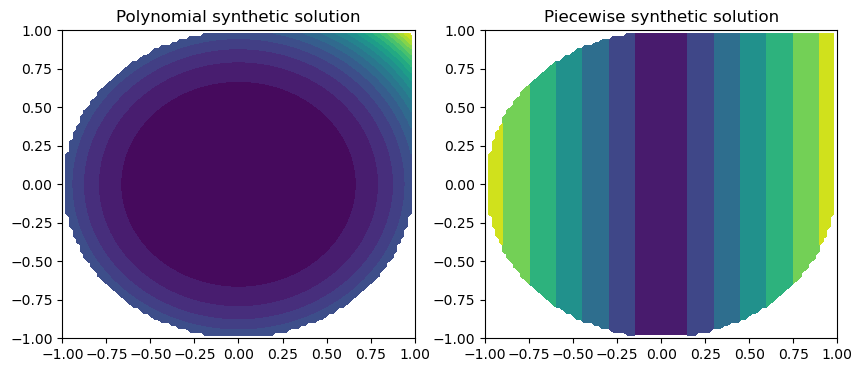

In [12]:
aX = np.linspace(-1,1,100)
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
plt.figure(figsize=[10,4])

plt.subplot(1,2,1)
plt.title('Polynomial synthetic solution')
u = FJ_exact_polynomial(X)
u[np.logical_not(FJ_domain.contains(X))]=np.nan
plt.contourf(*X,u,levels=20)

plt.subplot(1,2,2)
plt.title('Piecewise synthetic solution')
u = FJ_exact_piecewise(X)
u[np.logical_not(FJ_domain.contains(X))]=np.nan
plt.contourf(*X,u);

The following domain and synthetic solutions are considered in:

Froese, B. D., & Oberman, A. M. (2013). Convergent Filtered Schemes for the Monge-Ampère Partial Differential Equation. SIAM Journal on Numerical Analysis, 51(1), 423–444. http://doi.org/10.1137/120875065

In [13]:
FO_domain = box_dom
FO_x0 = np.array([0.5,0.5])

In [14]:
def squared_norm(x): return (x**2).sum(axis=0)

def FO_exact_exponential(x):
    x0 = fd.as_field(FO_x0,x.shape[1:])
    return np.exp(squared_norm(x-x0)/2) #np.exp(norm(x-x0,axis=0)**2/2)

def FO_exact_C1(x):
    x0 = fd.as_field(FO_x0,x.shape[1:])
    return 0.5*np.maximum(0.,norm(x-x0,axis=0)-0.2)**2
    
def FO_exact_singular(x):
    return -np.sqrt(np.maximum(2-squared_norm(x),1e-16**2))

def FO_exact_cone(x): # Not a viscosity solution !
    x0 = fd.as_field(FO_x0,x.shape[1:])
    return norm(x-x0,axis=0)

Let us emphasize that the cone example is *not* a viscosity solution of the Monge-Ampere equation. It is a Pogorelov solution, a weaker sort of solution. In particular, $\det(\nabla^2 u) = \delta_{x_0}$ is a Dirac mass, and not a classical function.

As a result, convergence is *not* expected in that case. We remove this example from our test suite.

In [15]:
data.update({
    'names':["Polynomial","Piecewise","Exponential","C1","Singular"],
    'exact':[FJ_exact_polynomial,FJ_exact_piecewise,FO_exact_exponential,FO_exact_C1,FO_exact_singular],
    'domain':[FJ_domain,FJ_domain,FO_domain,FO_domain,FO_domain],
})

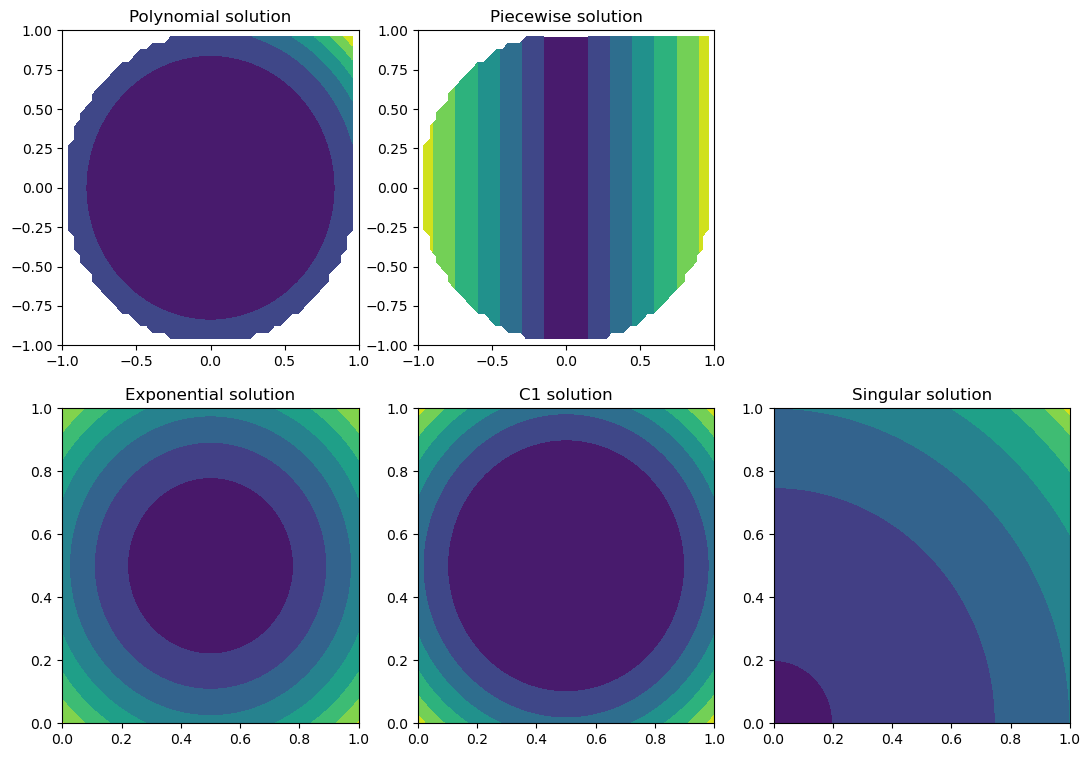

In [16]:
plt.figure(figsize=[13,9])

aX = np.linspace(-1,1); X = np.array(np.meshgrid(aX,aX,indexing='ij'))
for i,(name,exact) in enumerate(zip(data['names'][:2],data['exact'][:2])):
    plt.subplot(2,3,1+i)
    plt.title(name+' solution')
    u = exact(X)
    u[np.logical_not(FJ_domain.contains(X))]=np.nan
    plt.contourf(*X,u)

aX = np.linspace(0,1); X = np.array(np.meshgrid(aX,aX,indexing='ij'))
for i,(name,exact) in enumerate(zip(data['names'][2:],data['exact'][2:])):
    plt.subplot(2,3,4+i)
    plt.title(name+' solution')
    plt.contourf(*X,exact(X))

## 2. Problem data

### 2.1 Right hand side

The Monge-Ampere operator is defined as 
$$
    \det(\nabla^2 u(x)).
$$
The Pucci operator is defined as 
$$
    \lambda_{\min}(\nabla^2 u(x))+\mu\lambda_{\max}(\nabla^2 u(x)),
$$
where $\mu \geq 0$ is a parameter, and $\lambda_{\min}$ and $\lambda_{\max}$ denote the smallest and largest eigenvalue of a symmetric matrix.

An exact implementation of these operators, based on automatic differentiation, is implemented in the relevant notebooks and imported here.

### 2.2 Rotation by Pi/6

The base domains considered in the standard test cases have their sides aligned with the coordinate axes, which is non-generic and may give an unfair advantage to grid based methods. For this reason, we also consider a grid rotated by $\pi/6$ around the domain center.

In [17]:
FJ_rot = {'mult':lp.rotation(np.pi/6)}
FO_rot = {'mult':lp.rotation(np.pi/6),'center':FO_x0}

In [18]:
data['rotation']=[FJ_rot,FJ_rot,FO_rot,FO_rot,FO_rot]

### 2.3 Grid parameters

We use a square $n\times n$ discretization grid, where $n$ is referred to as the *resolution*.

In [19]:
data['resolution']=test_resolutions

A slightly larger grid is needed to accomodate the rotated examples. In order to keep the same sampling density, the resolution accounts for it.

In [20]:
rotation_extrawidth = np.sqrt(2.)*np.cos(np.pi/4-np.pi/6)

In [21]:
rotation_delta = rotation_extrawidth-1
FO_bounds = np.array([[0,1],[0,1]])
FO_bounds_rotated = np.array([[-rotation_delta/2,1+rotation_delta/2],[-rotation_delta/2,1+rotation_delta/2]])

FJ_bounds = np.array([[-1,1],[-1,1]])
FJ_bounds_rotated = rotation_extrawidth*FJ_bounds

In [22]:
data.update({
    'bounds':[FJ_bounds,FJ_bounds,FO_bounds,FO_bounds,FO_bounds],
    'bounds_rotated':[FJ_bounds_rotated,FJ_bounds_rotated,FO_bounds_rotated,FO_bounds_rotated,FO_bounds_rotated],
})

## 3. Pucci equation

In [23]:
def PucciRun(alpha, resolution_, rotation,  exact_, domain_, bounds_, bounds_rotated, 
             residue=False,verbosity=1):
    """
    Numerically solves a Pucci equation, and compares with known exact solution.
    The r.h.s. and Dirichlet boundary conditions are extracted from the provided synthetic solution.
    """
    # Setup parameters depending on the rotation
    exact,domain,resolution,bounds =  None,None,None,None
    if rotation is None:
        exact,domain,resolution,bounds = exact_,domain_,resolution_,bounds_
    else:
        domain=Domain.AffineTransform(domain_,**rotation)
        exact = lambda x : exact_(domain.reverse(x))
        bounds=bounds_rotated
        resolution = int(np.ceil(rotation_extrawidth*resolution_))

    aX0 = np.linspace(*bounds[0],resolution)
    aX1 = np.linspace(*bounds[1],resolution)
    X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))
    
    bc = Domain.Dirichlet(domain,exact,X)
    rhs = Pucci.Pucci_ad(exact,alpha,X)
    params = (alpha,rhs,bc)
    guess = np.zeros(bc.shape)
    
    stop = ad.Optimization.stop_default(verbosity=verbosity)
    
    #Test PDE residue, or difference w.r.t. exact solution
    error = (Pucci.SchemeConsistent(exact(X),alpha,rhs,bc) if residue else 
             exact(X) - ad.Optimization.newton_root(Pucci.SchemeConsistent_Opt, guess, params,stop=stop) )
    
    error[bc.not_interior]=0.
    #    plt.contourf(*X,error); plt.colorbar()
    return [norm(error,ord=1,averaged=True),norm(error,ord=2,averaged=True),norm(error,ord=np.inf)]

Solve the Pucci equation on the first domain.

In [24]:
PucciRun(0.5,50,None,data['exact'][0],data['domain'][0],data['bounds'][0],data['bounds_rotated'][0])

[0.0008015943680793589, 0.0010473941128313073, 0.0020608610816872665]

In [25]:
PucciRun(0.5,50,FJ_rot,data['exact'][0],data['domain'][0],data['bounds'][0],data['bounds_rotated'][0])

[0.0004124331806867701, 0.0007357003420076352, 0.001974057326535823]

Generate some numerical error data.

In [26]:
def PucciErrors(alpha,resolutions,rotation,i,**kwargs):
    errors = []
    rot=data['rotation'][i] if rotation else None
    for res in resolutions:
        errors.append(PucciRun(alpha,res,rot,
            data['exact'][i],data['domain'][i],data['bounds'][i],data['bounds_rotated'][i],**kwargs))
        
    title= r"Pucci equation, $\alpha=$"+str(alpha)
    title+=", "+data['names'][i]+" solution"
    if rotation: title+=", rotated domain"
        
    return np.array(errors),title

In [27]:
def PlotErrors(resolutions, errors, orders=[2]):
    plt.loglog(resolutions,errors[:,2],label=r"$L^\infty$",linestyle='-.')
    plt.loglog(resolutions,errors[:,0],label=r"$L^1$",linestyle='-')
    for order,linestyle in zip(orders,[':','--']):
        plt.loglog(resolutions,resolutions**-float(order),label="order="+str(order),linestyle=linestyle)
    plt.xlabel('resolution')
    plt.ylabel('error')
    plt.legend();

### 3.1 Smooth solutions

In [28]:
resolutions=data['resolution']
[data['names'][index] for index in (0,2)]

['Polynomial', 'Exponential']

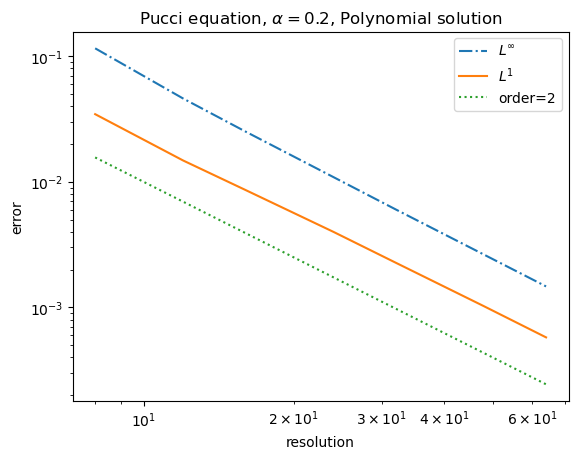

In [29]:
fig=plt.figure()
errors,title = PucciErrors(0.2,resolutions,False,0)
plt.title(title)
PlotErrors(resolutions,errors)
savefig(fig,"Pucci02_Polynomial.pdf")

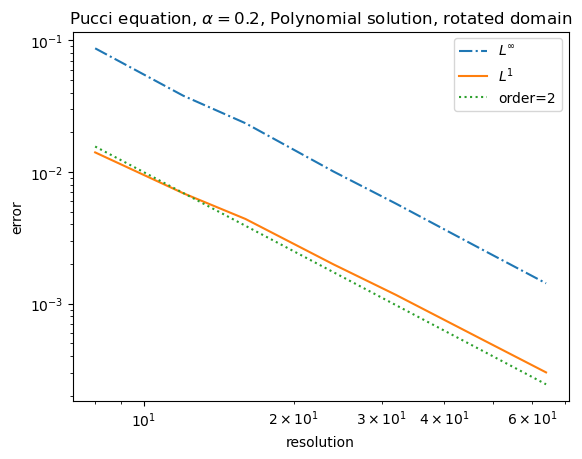

In [30]:
errors,title = PucciErrors(0.2,resolutions,True,0)
fig=plt.figure(); plt.title(title)
PlotErrors(resolutions,errors)
savefig(fig,"Pucci02_Polynomial_Rotated.pdf")
savefig(fig,"Pucci02_Polynomial_Rotated.png")

*Journal version*

<!---
fig=plt.figure(figsize=[3,2]); plt.title(r"Polynomial solution, $\mu=0.2$")
PlotErrors(resolutions,errors)
savefig(fig,"Pucci02_Polynomial_Rotated_request.pdf")
--->

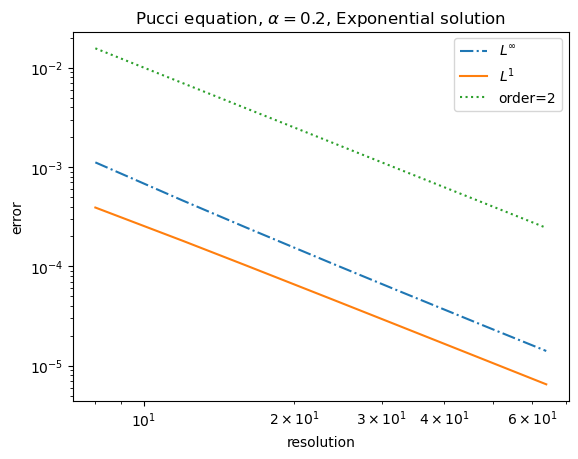

In [31]:
errors,title = PucciErrors(0.2,resolutions,False,2)
plt.title(title)
PlotErrors(resolutions,errors)

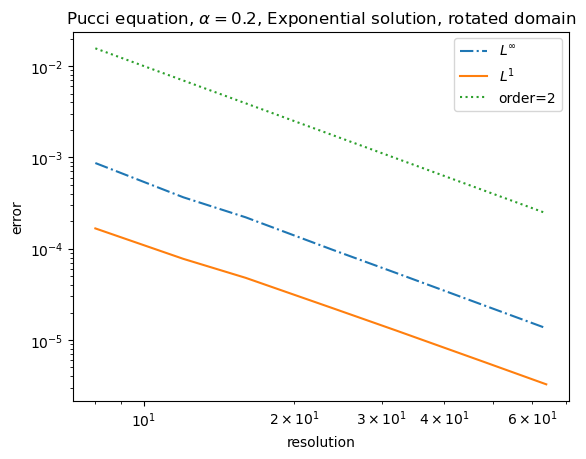

In [32]:
errors,title = PucciErrors(0.2,resolutions,True,2)
plt.title(title)
PlotErrors(resolutions,errors)

### 3.2 Non-smooth solutions

We consider two less smooth solutions:
* A $C^1$ solution, whose second order derivative is discontinuous over a curve (circle). Empirically, convergence rate is still quite fast, seemingly second order in the $L^1$ norm, and slightly below in the $L^\infty$ norm. 
* A singular solution, which is not differentiable at a point of the boundary. Empirically, second order convergence rate seems preserved in the $L^1$ norm, but a much slower convergence occurs in the $L^\infty$ norm.



In [33]:
resolutions=data['resolution']
[data['names'][index] for index in (3,4)]

['C1', 'Singular']

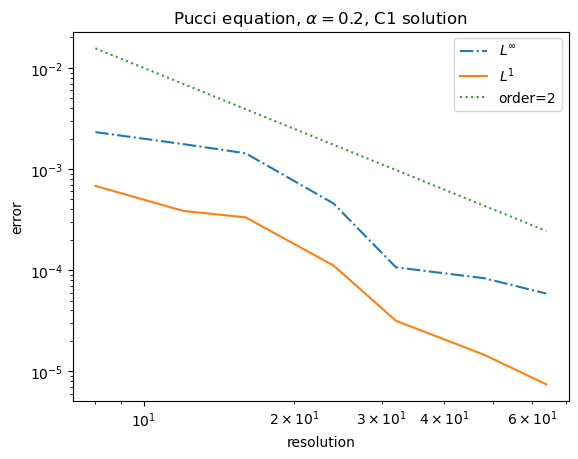

In [34]:
fig=plt.figure()
errors,title = PucciErrors(0.2,resolutions,False,3)
plt.title(title)
PlotErrors(resolutions,errors)
savefig(fig,"Pucci02_C1.pdf")

/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:45: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense2.py:98: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


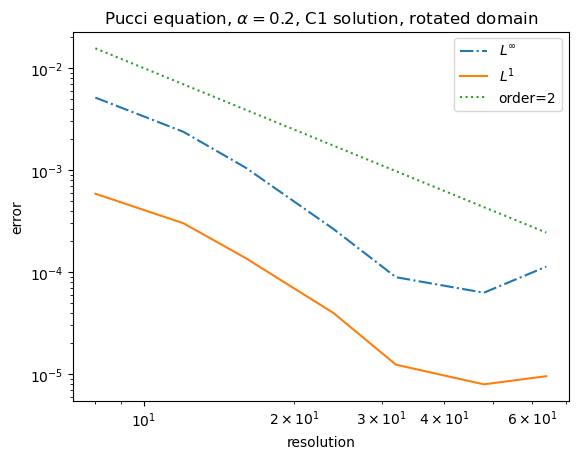

In [35]:
errors,title = PucciErrors(0.2,resolutions,True,3)
fig=plt.figure(); plt.title(title)
#Paper : fig=plt.figure(figsize=[4,2.5]); plt.title("C1 solution, $\mu=0.2$")
PlotErrors(resolutions,errors)
savefig(fig,"Pucci02_C1_Rotated.pdf")
savefig(fig,"Pucci02_C1_Rotated.png")

*Journal version*

<!---
fig=plt.figure(figsize=[3,2]); plt.title("C1 solution, $\mu=0.2$")
PlotErrors(resolutions,errors)
savefig(fig,"Pucci02_C1_Rotated_request.pdf")
--->

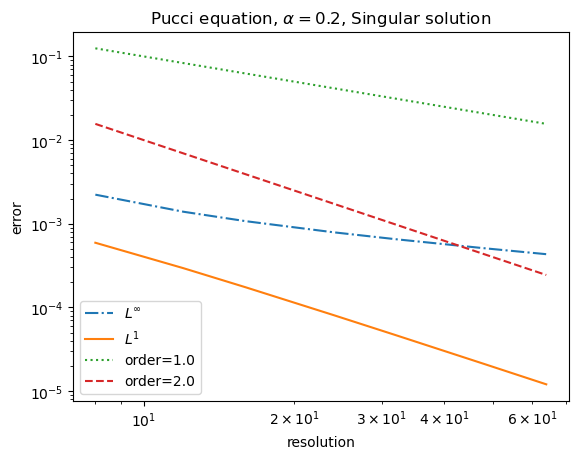

In [36]:
fig=plt.figure()
errors,title = PucciErrors(0.2,resolutions,False,4)
plt.title(title)
PlotErrors(resolutions,errors,orders=[1.,2.])
savefig(fig,"Pucci02_Singular.pdf")

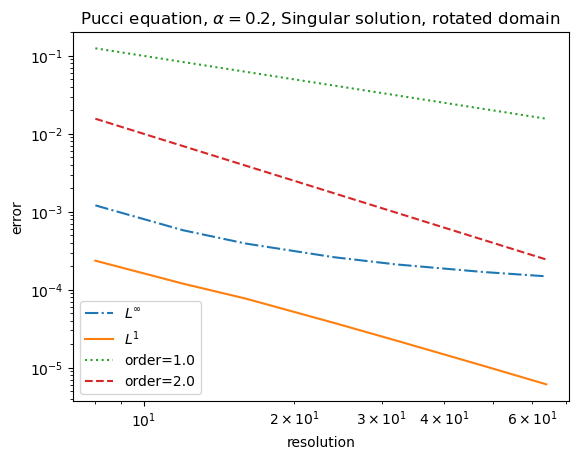

In [37]:
errors,title = PucciErrors(0.2,resolutions,True,4)
fig=plt.figure(); plt.title(title)
PlotErrors(resolutions,errors,orders=[1.,2.])
savefig(fig,"Pucci02_Singular_Rotated.pdf")
savefig(fig,"Pucci02_Singular_Rotated.png")

*Journal version*

<!---
fig=plt.figure(figsize=[3,2]); plt.title("Singular solution, $\mu=0.2$")
PlotErrors(resolutions,errors,orders=[2])
savefig(fig,"Pucci02_Singular_Rotated_request.pdf")
--->

## 4. Monge-Ampere

In [38]:
def MongeAmpereRun(SB, resolution_, rotation,  exact_, domain_, bounds_, bounds_rotated, 
             residue=False,verbosity=1):
    # Setup parameters depending on the rotation
    exact,domain,resolution,bounds =  None,None,None,None
    if rotation is None:
        exact,domain,resolution,bounds = exact_,domain_,resolution_,bounds_
    else:
        domain=Domain.AffineTransform(domain_,**rotation)
        exact = lambda x : exact_(domain.reverse(x))
        bounds=bounds_rotated
        resolution = int(np.ceil(rotation_extrawidth*resolution_))

    aX0 = np.linspace(*bounds[0],resolution)
    aX1 = np.linspace(*bounds[1],resolution)
    X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))
    
    bc = Domain.Dirichlet(domain,exact,X)
    rhs = MongeAmpere.MongeAmpere_ad(exact,X)
    params = (SB,rhs,bc)
    guess = np.zeros(bc.shape)
    
    stop = ad.Optimization.stop_default(verbosity=verbosity)
    
    #Test PDE residue, or difference w.r.t. exact solution
    error = (MongeAmpere.SchemeUniform(exact(X),SB,rhs,bc) if residue else 
             exact(X) - ad.Optimization.newton_root(MongeAmpere.SchemeUniform_Opt, guess, params,stop=stop) )
    
    error[bc.not_interior]=0.
    #    plt.contourf(*X,error); plt.colorbar()
    return [norm(error,ord=1,averaged=True),norm(error,ord=2,averaged=True),norm(error,ord=np.inf)]

In [39]:
def MongeAmpereErrors(SB,resolutions,rotation,i,**kwargs):
    errors = []
    rot=data['rotation'][i] if rotation else None
    for res in resolutions:
        errors.append(MongeAmpereRun(SB,res,rot,
            data['exact'][i],data['domain'][i],data['bounds'][i],data['bounds_rotated'][i],**kwargs))
        
    title= "Monge-Ampere, "+str(SB.shape[-1])+" superbases"
    title+=", "+data['names'][i]+" solution"
    if rotation: title+=", rotated"
        
    return np.array(errors),title

In [40]:
SB0 = Selling.SuperbasesForConditioning(5)
SB1 = Selling.SuperbasesForConditioning(15)
SB2 = Selling.SuperbasesForConditioning(30)

In [41]:
MongeAmpereRun(SB0,50,None,data['exact'][0],data['domain'][0],data['bounds'][0],data['bounds_rotated'][0])

[0.0008706635170048981, 0.001138008353950935, 0.002238453691942376]

### 4.1 Smooth solutions

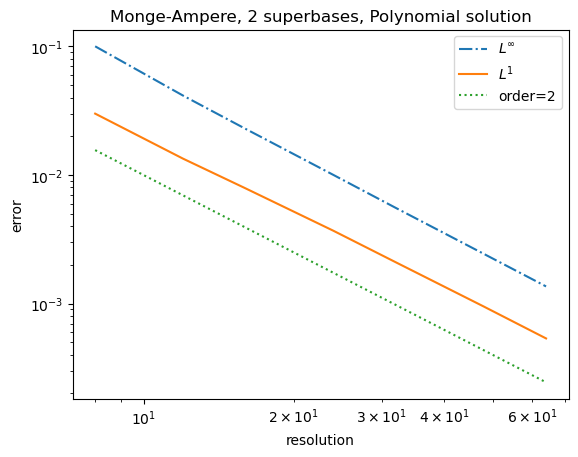

In [42]:
fig=plt.figure()
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB0,resolutions,False,0)
plt.title(title)
PlotErrors(resolutions,errors)
savefig(fig,"MongeAmpereSB0_Polynomial.pdf")

In [43]:
fig=plt.figure()
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB0,resolutions,True,0)
plt.title(title)
PlotErrors(resolutions,errors)
savefig(fig,"MongeAmpereSB0_Polynomial_Rotated.pdf")
savefig(fig,"MongeAmpereSB0_Polynomial_Rotated.png")

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [40]:
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB0,resolutions,False,2)
plt.title(title)
PlotErrors(resolutions,errors)

In [41]:
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB0,resolutions,True,2)
plt.title(title)
PlotErrors(resolutions,errors)

### 4.2 Non-smooth solutions

The $C^1$ solution has strongly anisotropic hessian, almost rank deficient on the neighborhood of a circle.
Increasing the number of superbases, from $2$ to $6$, is beneficial to accuracy, as could be expected. Changes are more modest when going to $10$ superbases, although quite visible in the $L^\infty$ norm.

In [42]:
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB0,resolutions,False,3)
plt.title(title)
PlotErrors(resolutions,errors)

In [43]:
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB1,resolutions,False,3)
plt.title(title)
PlotErrors(resolutions,errors)

In [44]:
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB2,resolutions,False,3)
plt.title(title)
PlotErrors(resolutions,errors)

Domain rotation has little impact in this example, since the solution (second-order) non-differentiability is along a circle.

In [69]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB0,resolutions,True,3)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB0_C1_Rotated=errors
savefig(fig,"MongeAmpereSB0_C1_Rotated.pdf")

../NumericalSchemes/AutomaticDifferentiation/misc.py:228: RuntimeWarning: divide by zero encountered in power
  def pow2(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
../NumericalSchemes/AutomaticDifferentiation/Dense2.py:88: RuntimeWarning: invalid value encountered in multiply
  return denseAD2(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


In [70]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB1,resolutions,True,3)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB1_C1_Rotated=errors
savefig(fig,"MongeAmpereSB1_C1_Rotated.pdf")

In [47]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB1,resolutions,True,3)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB2_C1_Rotated=errors
savefig(fig,"MongeAmpereSB2_C1_Rotated.pdf")

It is interesting to see the dependency of the numerical error w.r.t. the chosen stencil.

In [71]:
# Overlay of the results with different superbases.
fig=plt.figure()
plt.title("Monge-Ampere, 2 and 6 superbases, C1 solution, rotated")
plt.loglog(resolutions,errors_MongeAmpereSB0_C1_Rotated[:,2],label=r"$L^\infty$, 2 superbases",linestyle='--',color='C0')
plt.loglog(resolutions,errors_MongeAmpereSB1_C1_Rotated[:,2],label=r"$L^\infty$, 6 superbases",linestyle='-.',color='C0')
#plt.loglog(resolutions,errors_MongeAmpereSB2_C1_Rotated[:,2],label=r"$L^\infty$, 10 superbases",linestyle='-',color='C0')

plt.loglog(resolutions,errors_MongeAmpereSB0_C1_Rotated[:,0],label=r"$L^1$, 2 superbases",linestyle='--',color='C1')
plt.loglog(resolutions,errors_MongeAmpereSB1_C1_Rotated[:,0],label=r"$L^1$, 6 superbases",linestyle='-.',color='C1')
#plt.loglog(resolutions,errors_MongeAmpereSB2_C1_Rotated[:,0],label=r"$L^1$, 10 superbases",linestyle='-',color='C1')

plt.loglog(resolutions,0.1*resolutions**-2.,linestyle=':',color='C2')

plt.xlabel('resolution'); plt.ylabel('error')
plt.legend(loc='lower left')

savefig(fig,"MongeAmpereSB01_C1_Rotated.pdf")
savefig(fig,"MongeAmpereSB01_C1_Rotated.png")

A similar phenomenon occurs for the singular solution, especially when rotated, again in the $L^\infty$ norm.
Non-convergence, if too few superbases are used, is obvious.

In [49]:
resolutions=data['resolution']
errors,title = MongeAmpereErrors(SB0,resolutions,False,4)
plt.title(title)
PlotErrors(resolutions,errors)

In [72]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB0,resolutions,True,4)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB0_Singular_Rotated=errors
savefig(fig,"MongeAmpereSB0_Singular_Rotated.pdf")

In [73]:
errors,title = MongeAmpereErrors(SB1,data['resolution'],True,4)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB1_Singular_Rotated=errors
savefig(fig,"MongeAmpereSB1_Singular_Rotated.pdf")

In [74]:
errors,title = MongeAmpereErrors(SB2,data['resolution'],True,4)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB2_Singular_Rotated=errors
savefig(fig,"MongeAmpereSB2_Singular_Rotated.pdf")

In [75]:
# Overlay of the results with different superbases.
fig=plt.figure()
plt.title("Monge-Ampere, 2, 6 and 10 superbases, Singular solution, rotated")
plt.loglog(resolutions,errors_MongeAmpereSB0_Singular_Rotated[:,2],label=r"$L^\infty$, 2 superbases",linestyle='--',color='C0')
plt.loglog(resolutions,errors_MongeAmpereSB1_Singular_Rotated[:,2],label=r"$L^\infty$, 6 superbases",linestyle='-.',color='C0')
plt.loglog(resolutions,errors_MongeAmpereSB2_Singular_Rotated[:,2],label=r"$L^\infty$, 10 superbases",linestyle='-',color='C0')

plt.loglog(resolutions,errors_MongeAmpereSB0_Singular_Rotated[:,0],label=r"$L^1$, 2 superbases",linestyle='--',color='C1')
plt.loglog(resolutions,errors_MongeAmpereSB1_Singular_Rotated[:,0],label=r"$L^1$, 6 superbases",linestyle='-.',color='C1')
plt.loglog(resolutions,errors_MongeAmpereSB2_Singular_Rotated[:,0],label=r"$L^1$, 10 superbases",linestyle='-',color='C1')

plt.loglog(resolutions,0.07*resolutions**-2.,linestyle=':',color='C2')

plt.xlabel('resolution'); plt.ylabel('error')
plt.legend(loc='lower left')

savefig(fig,"MongeAmpereSB012_Singular_Rotated.pdf")
savefig(fig,"MongeAmpereSB012_Singular_Rotated.png")

### 4.3 Piecewise linear degenerate solution

Regarding the piecewise linear solution, we get an exact reconstruction, up to machine precision, if the discontinuity is aligned with the grid axes. This is independent of the resolution.

In [54]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB0,resolutions,False,1)
plt.title(title)
PlotErrors(resolutions,errors)
savefig(fig,"MongeAmpereSB0_Piecewise.pdf")

If one rotates the domain, the error is bounded, and does not converge to zero. It is dictated by the number of superbases used.

In [55]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB0,resolutions,True,1)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB0_Piecewise_Rotated = errors
savefig(fig,"MongeAmpereSB0_Piecewise_Rotated.pdf")

In [56]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB1,resolutions,True,1)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB1_Piecewise_Rotated = errors
savefig(fig,"MongeAmpereSB1_Piecewise_Rotated.pdf")

In [57]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB2,resolutions,True,1)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB2_Piecewise_Rotated = errors
savefig(fig,"MongeAmpereSB2_Piecewise_Rotated.pdf")

In [58]:
SB3=Selling.SuperbasesForConditioning(10**2)

In [59]:
fig=plt.figure()
errors,title = MongeAmpereErrors(SB3,resolutions,True,1)
plt.title(title)
PlotErrors(resolutions,errors)
errors_MongeAmpereSB3_Piecewise_Rotated = errors
savefig(fig,"MongeAmpereSB3_Piecewise_Rotated.pdf")

In [60]:
# Overlay of the results with different superbases.
fig=plt.figure()
plt.title("Monge-Ampere, 2, 6 and 10 superbases, Singular solution, rotated")
plt.loglog(resolutions,errors_MongeAmpereSB0_Piecewise_Rotated[:,2],label=r"$L^\infty$, 2 superbases",linestyle='--',color='C0')
plt.loglog(resolutions,errors_MongeAmpereSB1_Piecewise_Rotated[:,2],label=r"$L^\infty$, 6 superbases",linestyle='-.',color='C0')
#plt.loglog(resolutions,errors_MongeAmpereSB2_Piecewise_Rotated[:,2],label=r"$L^\infty$, 10 superbases",linestyle='-',color='C0')
plt.loglog(resolutions,errors_MongeAmpereSB3_Piecewise_Rotated[:,2],label=r"$L^\infty$, 22 superbases",linestyle='-',color='C0')


plt.loglog(resolutions,errors_MongeAmpereSB0_Piecewise_Rotated[:,0],label=r"$L^1$, 2 superbases",linestyle='--',color='C1')
plt.loglog(resolutions,errors_MongeAmpereSB1_Piecewise_Rotated[:,0],label=r"$L^1$, 6 superbases",linestyle='-.',color='C1')
#plt.loglog(resolutions,errors_MongeAmpereSB2_Piecewise_Rotated[:,0],label=r"$L^1$, 10 superbases",linestyle='-',color='C1')
plt.loglog(resolutions,errors_MongeAmpereSB3_Piecewise_Rotated[:,0],label=r"$L^1$, 22 superbases",linestyle='-',color='C1')


plt.loglog(resolutions,0.07*resolutions**-2.,linestyle=':',color='C2')

plt.xlabel('resolution'); plt.ylabel('error')
plt.legend(loc='lower left')

savefig(fig,"MongeAmpereSB013_Piecewise_Rotated.pdf")